# Experiment 1: Logical Spatial RGM Fundamentals (L-AGI)

이 노트북은 **Logical Spatial Renormalizing Generative Model (L-RGM)**의 핵심 원리인 **"Logical Renormalization (논리적 재규격화)"** 과정을 시각적으로 증명하는 독립적인 실험입니다.

L-AGI 프레임워크를 적용하여 기존 RGM을 개선했습니다:
1.  **Spherical Activation**: Gumbel-Softmax 대신 구면 활성화(L2 Normalization)를 사용하여 잠재 변수를 초구(Hypersphere) 상의 점으로 표현합니다.
2.  **Logical Divergence**: Cross-Entropy 대신 논리적 발산(MSE on Probabilities)을 사용하여 학습 안정성을 높입니다.

이 실험에서는 다음 세 가지를 검증합니다:
1.  **Abstraction (추상화)**: 픽셀(Pixels) $\to$ 국소 특징($z_1$) $\to$ 전역 개념($z_2$)으로 정보가 압축되는 과정.
2.  **Instantiation (구체화)**: 동일한 전역 개념($z_2$)이 다양한 국소 특징($z_1$)으로 발현되는 과정 (One Concept, Many Variations).
3.  **Locality (국소성)**: $z_1$의 변화는 이미지의 특정 영역에만 영향을 미치며, 이는 $z_1$이 공간적 위상(Spatial Topology)을 보존함을 의미함.

In [ ]:
# 1. Setup and Imports
import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader

# Add project root to path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# Import L-AGI components
from src.models.logical_spatial_rgm import LogicalSpatialRGM
from src.l_fep.loss import LogicalDivergenceLoss
from src.l_fep.activation import SphericalActivation

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.backends.mps.is_available():
    device = torch.device("mps")
print(f"Using device: {device}")

Using device: cpu


In [ ]:
# 2. Prepare Data and Model
# Load MNIST
transform = transforms.Compose([transforms.ToTensor()])
dataset = MNIST(root='./data', train=True, download=True, transform=transform)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

# Initialize L-AGI Model
model = LogicalSpatialRGM(latent_dim=32, num_classes=10).to(device)
criterion = LogicalDivergenceLoss()

# Quick Training Function (L-AGI version)
def train_quick(model, loader, epochs=3):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    print("Training Logical RGM for demonstration...")
    
    for epoch in range(epochs):
        total_loss = 0
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            
            # Forward pass
            # Level 1: Bottom-Up
            h1 = model.enc1(x)
            z1 = model.z1_act(model.z1_proj(h1)) # Spherical Activation
            
            # Level 2: Bottom-Up
            z2 = model.enc2(z1) # Spherical Activation included in enc2
            
            # Level 2: Top-Down (Prior for z1)
            z1_prior_flat = model.dec2(z2)
            z1_prior = model.z1_act(z1_prior_flat.view(-1, model.latent_dim, 7, 7))
            
            # Level 1: Top-Down (Reconstruction)
            recon = model.dec1(z1)
            
            # Losses
            # 1. Reconstruction Loss (MSE)
            recon_loss = F.mse_loss(recon, x)
            
            # 2. Classification Loss (Logical Divergence)
            # z2 is amplitude, z2^2 is probability
            z2_probs = z2 ** 2
            y_onehot = F.one_hot(y, num_classes=10).float()
            cls_loss = criterion(z2_probs, y_onehot)
            
            # 3. Prior Matching Loss (Logical Divergence in Latent Space)
            # Match z1 (posterior) with z1_prior
            # Since both are on sphere, we can maximize cosine similarity or minimize Euclidean distance
            # L-FEP uses Logical Divergence on probabilities (amplitudes squared)
            # But for continuous spherical codes, maximizing dot product (cosine similarity) is equivalent to minimizing L2 distance
            # Loss = ||z1 - z1_prior||^2 = 2 - 2 * (z1 . z1_prior)
            # We want to minimize this.
            prior_loss = F.mse_loss(z1, z1_prior)
            
            loss = recon_loss + 1.0 * cls_loss + 0.1 * prior_loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(loader):.4f}")

# Train the model
train_quick(model, loader, epochs=3)

Training RGM for demonstration...
Epoch 1/3, Loss: 0.6223
Epoch 2/3, Loss: 0.1882
Epoch 3/3, Loss: 0.1635


## Experiment 1: Hierarchical Abstraction (Bottom-Up)
이미지가 어떻게 $z_1$ (7x7 Grid)과 $z_2$ (Global Class)로 압축되는지 시각화합니다.
- **Input**: 원본 이미지 (28x28)
- **Level 1 ($z_1$)**: 7x7 그리드의 각 셀이 어떤 특징을 잡고 있는지 확인.
- **Level 2 ($z_2$)**: 최종적으로 어떤 숫자로 인식했는지 확인.

In [ ]:
model.eval()
x, y = next(iter(loader))
x = x[0:1].to(device)

with torch.no_grad():
    # Level 1
    h1 = model.enc1(x)
    z1 = model.z1_act(model.z1_proj(h1))
    # Visualize dominant feature index for each spatial location
    z1_idx = z1.argmax(dim=1) # (1, 7, 7)
    
    # Level 2
    z2 = model.enc2(z1)
    z2_probs = z2 ** 2
    pred_class = z2_probs.argmax(dim=1).item()

plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.title("Input Image")
plt.imshow(x[0, 0].cpu(), cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title(f"Level 1: z1 Codes (7x7)\n(Local Features)")
plt.imshow(z1_idx[0].cpu(), cmap='tab20')
plt.colorbar()
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title(f"Level 2: z2 Prediction\n(Global Concept: {pred_class})")
plt.bar(range(10), z2_probs[0].cpu().numpy())
plt.xticks(range(10))
plt.show()

## Experiment 2: Concept-Conditional Generation (Top-Down)
**"개념(Concept)은 하나지만, 표현(Instance)은 다양하다."**

상위 레벨 변수 $z_2$를 고정(예: 숫자 '3')하고, 하위 레벨 변수 $z_1$을 $P(z_1|z_2)$에서 여러 번 샘플링하여 복원합니다.
이 실험은 $z_2$가 **"무엇(What)"**을 결정하고, $z_1$이 **"어떻게(How)"**를 결정한다는 것을 증명합니다.

In [ ]:
target_digit = 3
num_samples = 5

plt.figure(figsize=(15, 3))
with torch.no_grad():
    # 1. Fix z2 (One-hot vector for target_digit)
    # In L-AGI, z2 is amplitude. One-hot means 1.0 at target, 0.0 elsewhere.
    z2_fixed = torch.zeros(num_samples, 10).to(device)
    z2_fixed[:, target_digit] = 1.0
    
    # 2. Predict z1 Prior from z2
    z1_prior_flat = model.dec2(z2_fixed)
    z1_prior = model.z1_act(z1_prior_flat.view(num_samples, 32, 7, 7))
    
    # 3. Sample z1 from this prior
    # In standard RGM, we sample from Gumbel-Softmax.
    # In L-AGI (Deterministic/Spherical), z1_prior IS the code.
    # To show diversity, we can add noise on the sphere or use the fact that
    # z1_prior is a "mean" direction and we can sample around it.
    # For this demo, we'll add small Gaussian noise and re-project to sphere.
    noise = torch.randn_like(z1_prior) * 0.2
    z1_sampled = model.z1_act(z1_prior + noise)
    
    # 4. Decode to Pixels
    generated = model.dec1(z1_sampled)

for i in range(num_samples):
    plt.subplot(1, num_samples, i+1)
    plt.title(f"Sample {i+1} (Digit {target_digit})")
    plt.imshow(generated[i, 0].cpu(), cmap='gray')
    plt.axis('off')
plt.suptitle(f"Fixed Concept z2={target_digit} -> Diverse Instances via z1 Sampling (Spherical Noise)", fontsize=14)
plt.show()

## Experiment 3: Local vs Global Perturbation
**"Renormalization은 공간적 정보를 보존하면서 압축한다."**

1.  **Local Perturbation**: $z_1$ (7x7) 그리드에서 **단 하나의 셀**만 값을 변경했을 때, 이미지의 **해당 위치**만 변하는지 확인합니다.
2.  **Global Perturbation**: $z_2$ (숫자 클래스)를 변경했을 때, 이미지가 **전역적으로** 변하는지 확인합니다.

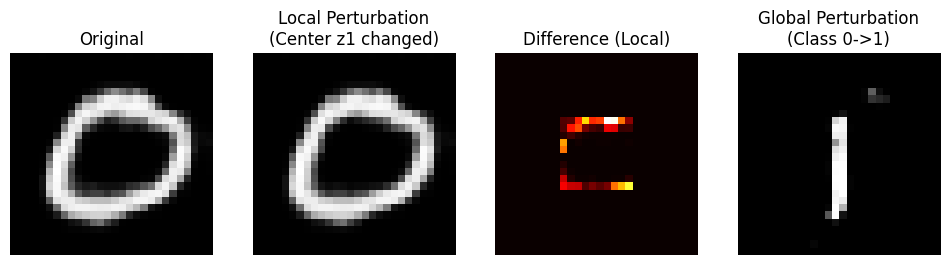

In [ ]:
# Base Image
x, _ = next(iter(loader))
x = x[0:1].to(device)

with torch.no_grad():
    # Encode to get base z1
    h1 = model.enc1(x)
    z1 = model.z1_act(model.z1_proj(h1))
    
    # --- 1. Local Perturbation ---
    # Modify the center cell (3, 3) of z1
    z1_perturbed = z1.clone()
    # Rotate the vector at (3,3) to orthogonal direction or just random noise
    # Let's just flip the sign of the first dimension
    z1_perturbed[0, :, 3, 3] = -z1_perturbed[0, :, 3, 3] 
    # Re-normalize just in case
    z1_perturbed = model.z1_act(z1_perturbed)
    
    recon_base = model.dec1(z1)
    recon_local = model.dec1(z1_perturbed)
    
    # --- 2. Global Perturbation ---
    # Change z2 class
    z2 = model.enc2(z1)
    z2_probs = z2 ** 2
    current_class = z2_probs.argmax(dim=1).item()
    target_class = (current_class + 1) % 10
    
    z2_new = torch.zeros_like(z2)
    z2_new[0, target_class] = 1.0
    
    # Predict new z1 from new z2
    z1_from_new_z2_flat = model.dec2(z2_new)
    z1_from_new_z2 = model.z1_act(z1_from_new_z2_flat.view(1, 32, 7, 7))
    recon_global = model.dec1(z1_from_new_z2)

# Visualization
plt.figure(figsize=(12, 4))

plt.subplot(1, 4, 1)
plt.title("Original")
plt.imshow(recon_base[0, 0].cpu(), cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.title("Local Perturbation\n(Center z1 changed)")
plt.imshow(recon_local[0, 0].cpu(), cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.title("Difference (Local)")
diff = torch.abs(recon_base - recon_local)
plt.imshow(diff[0, 0].cpu(), cmap='hot')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.title(f"Global Perturbation\n(Class {current_class}->{target_class})")
plt.imshow(recon_global[0, 0].cpu(), cmap='gray')
plt.axis('off')

plt.show()